In [ ]:
import time
import numpy as np
import healpy as hp
from tqdm import tqdm
import multiprocessing

print("Started")

def RVector(t):
    theta1 = 7.5*np.pi / 180
    theta2 = 85*np.pi / 180
    w1 = 2*np.pi  #rad/min
    w2 = 2*w1 #rad/min
    w3 = 0.000011954  #rad/min

    A=[[np.cos(w1*t),np.sin(w1*t),0],
       [-np.sin(w1*t),np.cos(w1*t),0],
       [0,0,1]]

    B=[[1,0,0],
       [0,np.cos(w2*t),np.sin(w2*t)],
       [0,-np.sin(w2*t),np.cos(w2*t)]]

    C=[[np.cos(theta1),0,np.sin(theta1)],
       [0,1,0],
       [-np.sin(theta1),0,np.cos(theta1)]]

    D=[[np.cos(theta2)],
       [np.sin(theta2)*np.cos(w3*t)],
       [np.sin(theta2)*np.sin(w3*t)]]

    result1 = np.matmul(A,B)
    result2 = np.matmul(result1,C)
    result = np.matmul(result2,D)

    return result

def SVector(t):
    theta1 = 7.5*np.pi / 180
    theta2 = 0
    w1 = 2*np.pi  #rad/min
    w2 = 2*w1 #rad/min
    w3 = 0.000011954  #rad/min

    A=[[np.cos(w1*t),np.sin(w1*t),0],
       [-np.sin(w1*t),np.cos(w1*t),0],
       [0,0,1]]

    B=[[1,0,0],
       [0,np.cos(w2*t),np.sin(w2*t)],
       [0,-np.sin(w2*t),np.cos(w2*t)]]

    C=[[np.cos(theta1),0,np.sin(theta1)],
       [0,1,0],
       [-np.sin(theta1),0,np.cos(theta1)]]

    D=[[np.cos(theta2)],
       [-np.sin(theta2)*np.cos(w3*t)],
       [-np.sin(theta2)*np.sin(w3*t)]]

    result1 = np.dot(A,B)
    result2 = np.dot(C,D)
    result = np.dot(result1,result2)
    return result

# angular saperation between two pixel
def ang_distance(theta1,theta2,phi1,phi2):
    # cos(∆θ) = sin(θ1)sin(θ2)cos(φ1 - φ2) + cos(θ1)cos(θ2)
    theta = np.arccos(np.cos(theta1) * np.cos(theta2) + np.sin(theta1) * np.sin(theta2) * np.cos(phi1 - phi2))
    return theta

def process_time_step(time_step):

    t = time_step

    # 1. Calculate R(t) and S(t) vectors
    R = RVector(t)
    S = SVector(t)

    # 2. Calculate pixel number along R(t) vector (ring format)
    theta_R, phi_R = hp.vec2ang(R)
    pix_ring = hp.ang2pix(nside, theta=theta_R, phi=phi_R)

    # 3. Convert to NEST format
    #nest_pix = hp.ring2nest(nside, pic_ring)

    # 4. Find neighboring pixels in NEST format
    # neighbours = hp.get_all_neighbours(nside, nest_pix,nest=True)
    neighbours = hp.query_disc(nside, R , radius=(3*sigma))

    # 5. angular separation central pixel to neighbor
    theta_separations = np.zeros_like(neighbours)
    for i, neighbour_pix in enumerate(neighbours):
        theta_neighbour, phi_neighbour = hp.pix2ang(nside, neighbour_pix)
        theta_separations[i] = ang_distance(theta_R, theta_neighbour, phi_R, phi_neighbour)

    # 6. Retrieve temperatures of neighboring pixels
    neighbor_temperatures = temperature_map[neighbours]

    # 7. Apply the beam convolution
    convolved_temperature = np.sum(neighbor_temperatures * np.exp(-theta_separations**2 / (2 * sigma**2))) / np.sum(np.exp(-theta_separations**2 / (2 * sigma**2)))

    return int(pix_ring),convolved_temperature
theta1 = 7.5*np.pi / 180
theta2 = 85*np.pi / 180
w1 = 2*np.pi  #rad/min
w2 = 2*w1 #rad/min
w3 = 0.000011954  #rad/min

nside=1024
npix = 12*nside**2

# time_step=scan_time
scan_time = np.sqrt(4*np.pi/npix)/w1

sigma = np.radians(10/60)

temperature_map = hp.read_map("input_map.fits")

start = time.time()

start_time=0
duration = 60*24*30 #in min (one month)
steps = int(duration / scan_time)

time_periods = np.linspace(start_time, start_time + steps*scan_time, steps)
time_periods_iterator = tqdm(time_periods, desc="Processing", total=len(time_periods))
def parallel_execution(chunk):
    results = []
    for time_period in tqdm(chunk, desc="Processing"):
        pixel, temperature = process_time_step(time_period)
        results.append((time_period, pixel, temperature))
    return results

start = time.time()

# Split the time_periods array into chunks for parallel processing
chunks = np.array_split(time_periods, 48)

# Using multiprocessing for parallel execution
with multiprocessing.Pool(processes=48) as pool:
    results = pool.map(parallel_execution, chunks)

print("result processing")
# Flatten the results list of lists
results = [item for sublist in results for item in sublist]

# Write results to the file
file_path = 'Data/1month.dat'
np.savetxt(file_path, results, fmt='%.4f %d %.4f')
print(f"Results saved to {file_path}")

end = time.time()
elapsed_time = end - start
print(f"Total execution time: {elapsed_time:.2f} seconds")

In [ ]:
# To a file pixels(0 to npix)|tot_temperature(zero)|occurance(zero)|avg_temp(zero)

import numpy as np

nside = 1024
npix = 12*nside*nside

pix = np.arange(0,npix)
temp = np.zeros(npix)
occurance = np.zeros(npix)
avg_temp = np.zeros(npix)

data = np.coloumn_stack((pix, temp, occurance, avg_temp))
np.savetxt('map.dat',data,fmt = '%d %.4f %d %.4f')

In [ ]:
# Output : map1.dat pixels|tot_temperature|occurance|avg_temp

import numpy as np

map_data = np.loadtxt("map.dat")
map_array = np.loadtxt("month1.dat")

for i in range(len(map_array)):
    pix = int(map_array[i][1])
    map_data[pix][1] += map_array[i][2]
    map_data[pix][2] += 1

for i in range(len(map_data)):
    if map_dfata[i][2] != 0:
        map_data[i][3] = map_data[i][1]/map_data[i][2]

np.savetxt("map1.dat", map_data, fmt = '%d %.4f %d %.4f')

In [ ]:
import numpy as np
import healpy as hp

map_file1 = np.loadtxt("map1.dat")
map = np.zeros(len(map_file))
map = map_file[:, 3]
hp.mollview(map)

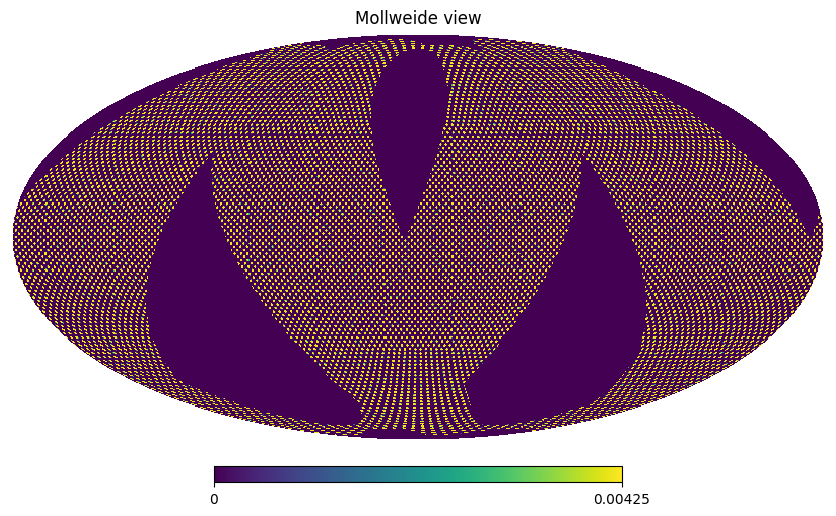

In [11]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

npix = 12 * 1024 ** 2
i = [1, 2, 3, 4, 5] 

temp = np.zeros(npix)
occurance = np.zeros(npix)
avg_temp = np.zeros(npix)

# Load data from each file and store the fourth column in the list
for idx in i:
    filename = f"map{idx}.dat"
    map_data = np.loadtxt(filename)
    temp += map_data[:, 1]
    occurance += map_data[:, 2]

for i in range(npix):
    if occurance[i] != 0:
        avg_temp[i] = temp[i] / occurance[i]

map = avg_temp
hp.mollview(map)
plt.savefig("image.png")